## Cellpose-SAM: superhuman generalization for cellular segmentation

Marius Pachitariu, Michael Rariden, Carsen Stringer

[paper](https://www.biorxiv.org/content/10.1101/2025.04.28.651001v1) | [code](https://github.com/MouseLand/cellpose)

This notebook shows how to process your own 2D or 3D images, saved on Google Drive.

This notebook is adapted from the notebook by Pradeep Rajasekhar, inspired by the [ZeroCostDL4Mic notebook series](https://github.com/HenriquesLab/ZeroCostDL4Mic/wiki).

### Make sure you have GPU access enabled by going to Runtime -> Change Runtime Type -> Hardware accelerator and selecting GPU

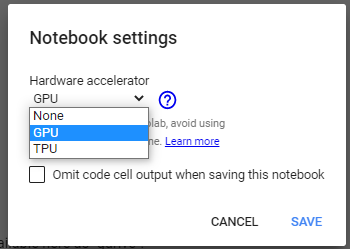

### Mount your google drive

Run this cell to connect your Google Drive to colab:
* Click on the URL.
* Sign in your Google Account.

You will either have to:
* copy the authorisation code and enter it into box below OR
* in the new google colab, you can just click "Allow" and it should connect.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import random
import tifffile

def extract_random_frame(tif_path, output_folder):
    # Загружаем многокадровое TIFF-видео
    video = tifffile.imread(tif_path)

    # Проверяем количество кадров
    num_frames = video.shape[0]

    # Выбираем случайный индекс кадра
    random_index = random.randint(0, num_frames - 1)
    frame = video[random_index]

    # Создаем папку, если не существует
    os.makedirs(output_folder, exist_ok=True)

    # Путь для сохранения
    output_path = os.path.join(output_folder, f"random_frame_{random_index}.tif")

    # Сохраняем кадр в формате TIFF
    tifffile.imwrite(output_path, frame)

    print(f"Случайный кадр сохранён: {output_path}")

# Пример использования
tif_path = "/content/drive/MyDrive/1.tif"
output_folder = "/content/drive/MyDrive/cellpose"
extract_random_frame(tif_path, output_folder)


Случайный кадр сохранён: /content/drive/MyDrive/cellpose/random_frame_49.tif



Then click on "Folder" icon on the Left, press the refresh button. Your Google Drive folder should now be available here as "gdrive".


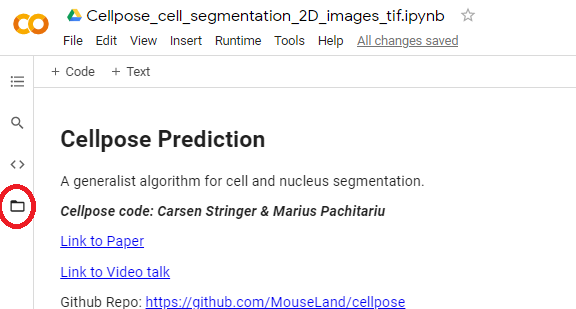

Click on the triangle icon and it will allow you to access whole drive. Navigate to the folder containing your images. Once you are there, click on the three dots on the right of the folder and select "Copy Path"

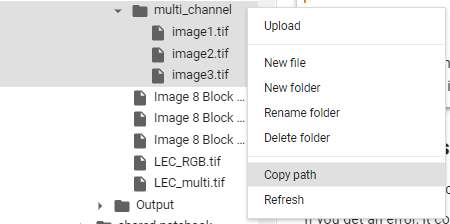

Copy and paste this path in the **dir** string below

### Install Cellpose-SAM


In [3]:
!pip install git+https://www.github.com/mouseland/cellpose.git

  Cloning https://www.github.com/mouseland/cellpose.git to /tmp/pip-req-build-b3821fvx
  Running command git clone --filter=blob:none --quiet https://www.github.com/mouseland/cellpose.git /tmp/pip-req-build-b3821fvx
  Resolved https://www.github.com/mouseland/cellpose.git to commit 1ca75d9f3acea76d94360f952b3399e65ee2046d
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 88.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 77.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
  

Check GPU and instantiate model - will download weights.

In [4]:
import numpy as np
from cellpose import models, core, io, plot
from pathlib import Path
from tqdm import trange
import matplotlib.pyplot as plt
from natsort import natsorted

io.logger_setup() # run this to get printing of progress

#Check if colab notebook instance has GPU access
if core.use_gpu()==False:
  raise ImportError("No GPU access, change your runtime")

model = models.CellposeModel(gpu=True)



Welcome to CellposeSAM, cellpose v
cellpose version: 	4.0.3.dev19+g1ca75d9 
platform:       	linux 
python version: 	3.11.12 
torch version:  	2.6.0+cu124! The neural network component of
CPSAM is much larger than in previous versions and CPU excution is slow. 
We encourage users to use GPU/MPS if available. 


creating new log file
2025-05-14 11:35:19,835 [INFO] WRITING LOG OUTPUT TO /root/.cellpose/run.log
2025-05-14 11:35:19,836 [INFO] 
cellpose version: 	4.0.3.dev19+g1ca75d9 
platform:       	linux 
python version: 	3.11.12 
torch version:  	2.6.0+cu124
2025-05-14 11:35:20,117 [INFO] ** TORCH CUDA version installed and working. **
2025-05-14 11:35:20,118 [INFO] ** TORCH CUDA version installed and working. **
2025-05-14 11:35:20,120 [INFO] >>>> using GPU (CUDA)
2025-05-14 11:35:24,429 [INFO] Downloading: "https://huggingface.co/mouseland/cellpose-sam/resolve/main/cpsam" to /root/.cellpose/models/cpsam



100%|██████████| 1.15G/1.15G [00:11<00:00, 104MB/s]


Input directory with your images:

In [5]:
# *** change to your google drive folder path ***
dir = "/content/drive/MyDrive/cellpose/"
dir = Path(dir)
if not dir.exists():
  raise FileNotFoundError("directory does not exist")

# *** change to your image extension ***
image_ext = ".tif"

# list all files
files = natsorted([f for f in dir.glob("*"+image_ext) if "_masks" not in f.name and "_flows" not in f.name])

if(len(files)==0):
  raise FileNotFoundError("no image files found, did you specify the correct folder and extension?")
else:
  print(f"{len(files)} images in folder:")

for f in files:
  print(f.name)

1 images in folder:
random_frame_49.tif


## Run Cellpose-SAM on one image in folder

Here are some of the parameters you can change:

* ***flow_threshold*** is  the  maximum  allowed  error  of  the  flows  for  each  mask.   The  default  is 0.4.
    *  **Increase** this threshold if cellpose is not returning as many masks as you’d expect (or turn off completely with 0.0)
    *   **Decrease** this threshold if cellpose is returning too many ill-shaped masks.

* ***cellprob_threshold*** determines proability that a detected object is a cell.   The  default  is 0.0.
    *   **Decrease** this threshold if cellpose is not returning as many masks as you’d expect or if masks are too small
    *   **Increase** this threshold if cellpose is returning too many masks esp from dull/dim areas.

* ***tile_norm_blocksize*** determines the size of blocks used for normalizing the image. The default is 0, which means the entire image is normalized together.
  You may want to change this to 100-200 pixels if you have very inhomogeneous brightness across your image.



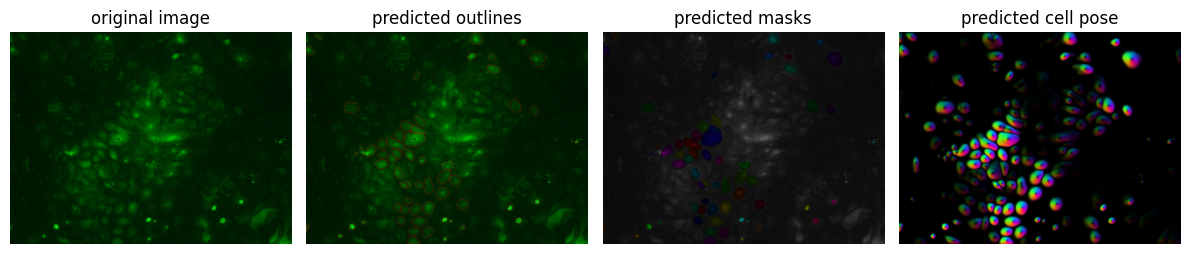

In [25]:
img = io.imread(files[0])

flow_threshold = 0.4
cellprob_threshold = 0.0
tile_norm_blocksize = 0

masks, flows, styles = model.eval(img, batch_size=32, flow_threshold=flow_threshold, cellprob_threshold=cellprob_threshold,
                                  normalize={"tile_norm_blocksize": tile_norm_blocksize})

fig = plt.figure(figsize=(12,5))
plot.show_segmentation(fig, img, masks, flows[0])
plt.tight_layout()
plt.show()


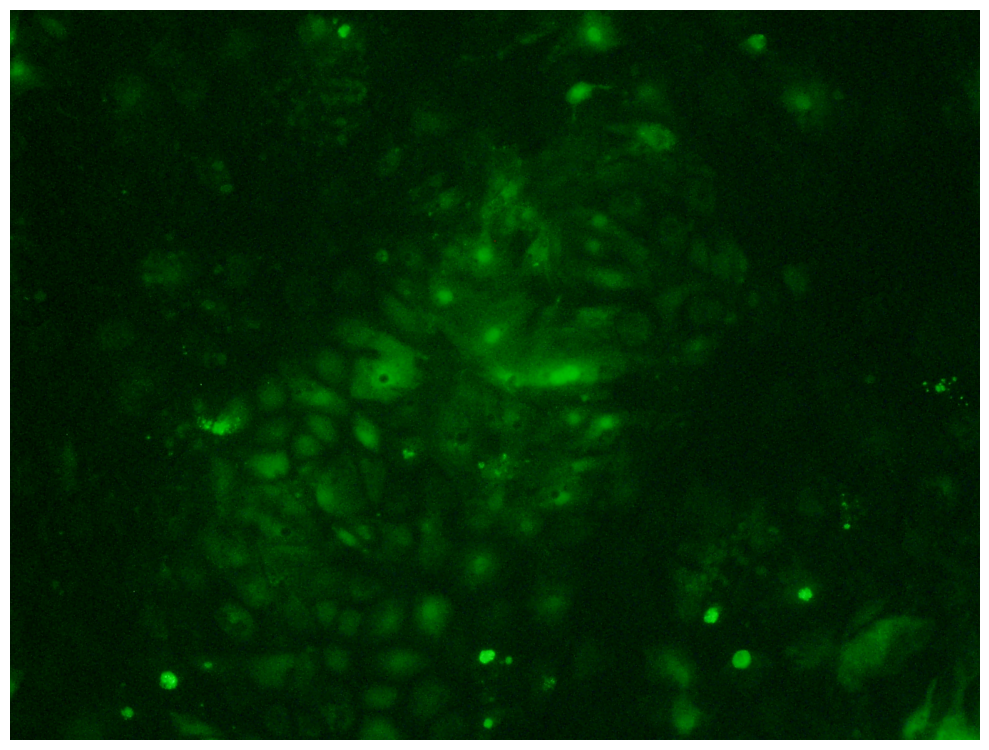

In [63]:
fig, axes = plt.subplots(nrows=1, figsize=(10, 20))  # 3 строки, 1 столбец, большая фигура

# Исходное изображение
axes.imshow(img, cmap='gray')
# axes[0].set_title('Original Image')
axes.axis('off')

# # Маски
# axes[1].imshow(flows[0], cmap='jet')
# axes[1].set_title('Masks')
# axes[1].axis('off')



plt.tight_layout()
plt.show()

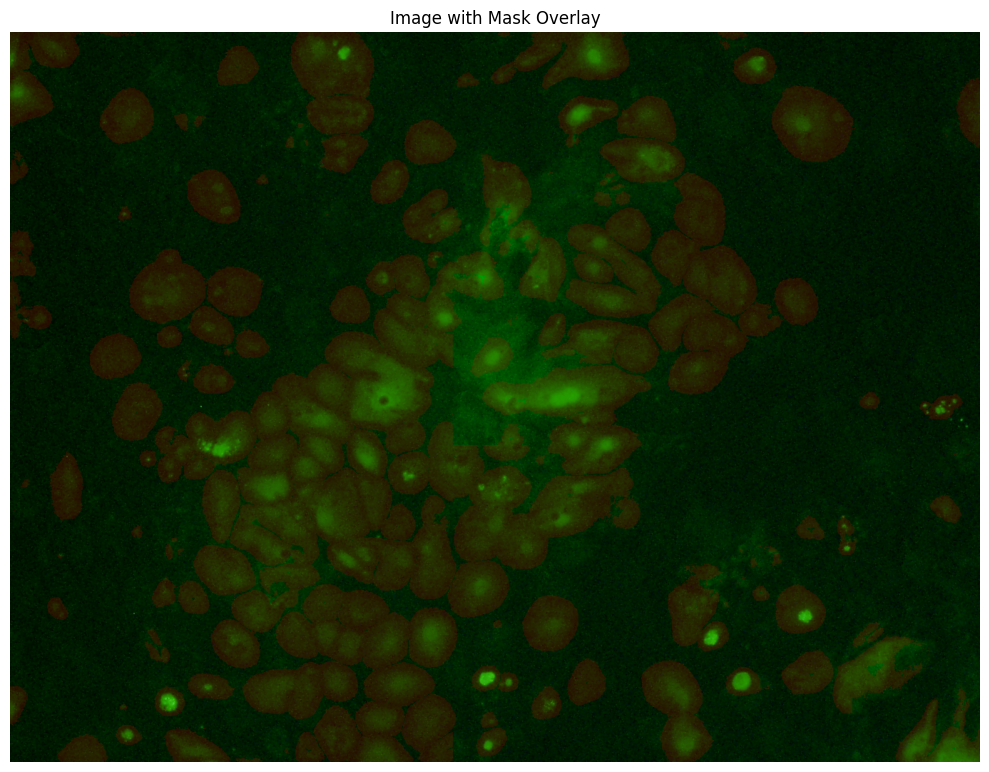

In [55]:
# Преобразуем изображение в RGB, если оно ч/б
if img.ndim == 2:
    img_rgb = np.stack([img]*3, axis=-1)
else:
    img_rgb = img.copy()

# Создаем копию для наложения маски
overlay = img_rgb.copy()

# Индексы, где маска присутствует
mask_indices = flows[0] > 1
mask_indices = mask_indices.sum(axis = -1) > 1

# Красный цвет наложения
overlay[mask_indices] = [255, 0, 0]

# Визуализация с альфа-прозрачностью
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img_rgb)
ax.imshow(overlay, alpha=0.15)  # полупрозрачная маска
ax.set_title('Image with Mask Overlay')
ax.axis('off')
plt.tight_layout()
plt.show()

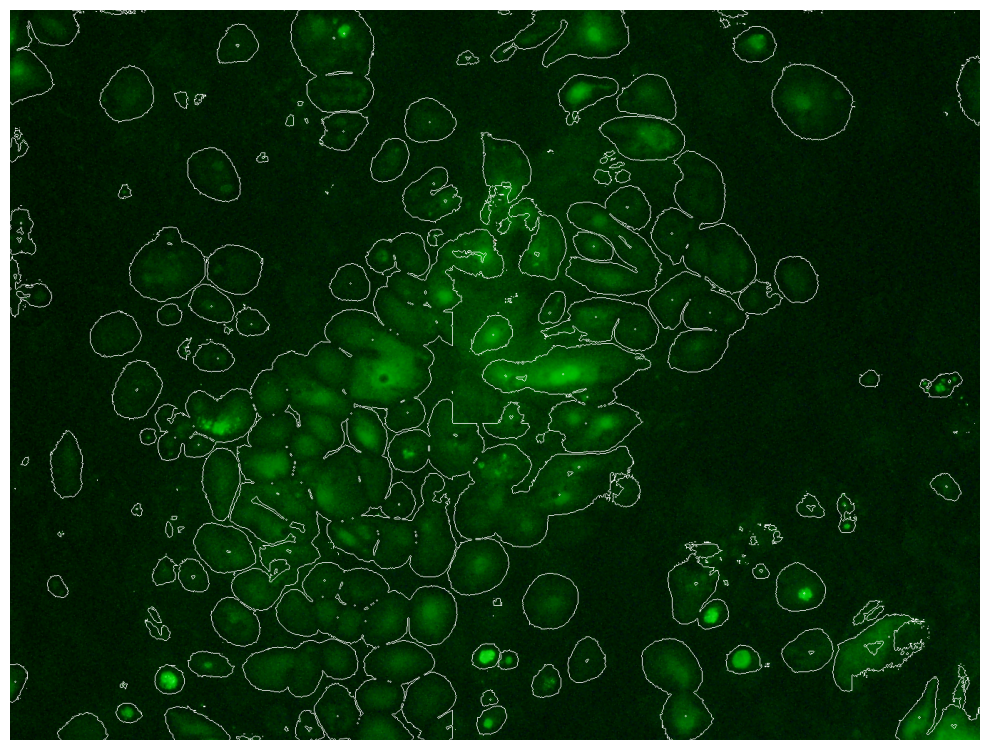

In [61]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import io
from skimage.segmentation import find_boundaries

# Преобразуем изображение в RGB, если оно ч/б
if img.ndim == 2:
    img_rgb = np.stack([img]*3, axis=-1)
else:
    img_rgb = img.copy()

# Используем потоки для генерации маски
mask_indices = flows[0] > 1
mask_indices = mask_indices.sum(axis=-1) > 1

# Находим границы
boundaries = find_boundaries(mask_indices, mode='inner')

# Копия изображения для наложения границ
overlay = img_rgb.copy()

# Максимально яркие границы — белым цветом
overlay[boundaries] = [255, 255, 255]

# Визуализация без заливки, только границы
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(overlay)
ax.axis('off')
plt.tight_layout()
plt.show()


## Run Cellpose-SAM on folder of images

if you have many large images, you may want to run them as a loop over images



In [ ]:
masks_ext = ".png" if image_ext == ".png" else ".tif"
for i in trange(len(files)):
    f = files[i]
    img = io.imread(f)
    masks, flows, styles = model.eval(img, batch_size=32, flow_threshold=flow_threshold, cellprob_threshold=cellprob_threshold,
                                  normalize={"tile_norm_blocksize": tile_norm_blocksize})
    io.imsave(dir / (f.stem + "_masks" + masks_ext), masks)

if you have small images, you may want to load all of them first and then run, so that they can be batched together on the GPU

In [ ]:
print("loading images")
imgs = [io.imread(files[i]) for i in trange(len(files))]

print("running cellpose-SAM")
masks, flows, styles = model.eval(imgs, batch_size=32, flow_threshold=flow_threshold, cellprob_threshold=cellprob_threshold,
                                  normalize={"tile_norm_blocksize": tile_norm_blocksize})

print("saving masks")
for i in trange(len(files)):
    f = files[i]
    io.imsave(dir / (f.stem + "_masks" + masks_ext), masks[i])

to save your masks for ImageJ, run the following code:

In [ ]:
for i in trange(len(files)):
    f = files[i]
    masks0 = io.imsave(dir / (f.name + "_masks" + masks_ext))
    io.save_rois(masks0, f)